# IIC-3641 GML UC

## Actividad en clase

Vamos a usar GCN para trabajar con el dataset CORA:

- Modifique la arquitectura de la clase Net hasta lograr que el accuracy sea mejor que el que mostré en clases.
- Defina una función de early stopping que guarde los modelos cuando se obtengan mejoras en la función de pérdida. Puede detener el entrenamiento con un parámetro patience que hace un break si no se obtienen mejoras despues de una cantidad determinada de epochs.
- Grafique las funciones de pérdida y de accuracy.
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que las L otorgan un bono en la nota final de la asignatura.

***Tiene hasta el final de la clase.***

In [1]:
import torch
print(torch.__version__)

2.4.1+cu118


In [2]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import time
import numpy as np

gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

In [3]:
from dgl.data import CoraGraphDataset


def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    return g, features, labels, train_mask, test_mask

In [4]:
g, features, labels, train_mask, test_mask = load_cora_data()
g.add_edges(g.nodes(), g.nodes())

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 64)
        self.layer2 = GCNLayer(64, 7)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x


net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=64, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=64, out_features=7, bias=True)
  )
)


In [7]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth'):
        """
        Args:
            patience (int): Número de épocas que esperará sin mejora antes de detener el entrenamiento.
            delta (float): Mínima mejora requerida para ser considerada una mejora.
            path (str): Ruta para guardar el mejor modelo.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el mejor modelo cuando ocurre una mejora en la pérdida de validación.'''
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Uso en el ciclo de entrenamiento:
early_stopping = EarlyStopping(patience=3, delta=0.001)

In [9]:
optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []

train_losses = []
test_acc = []

for epoch in range(50):
    if epoch >= 0:
        t0 = time.time()
    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 0:
        dur.append(time.time() - t0)
    acc = evaluate(net, g, features, labels, test_mask)
    print(
        "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)
        )
    )
    
    test_acc.append(acc)
    
    early_stopping(loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    

Epoch 00000 | Loss 1.9538 | Test Acc 0.2270 | Time(s) 0.0183
Validation loss decreased (inf --> 1.953823). Saving model...
Epoch 00001 | Loss 1.6977 | Test Acc 0.5530 | Time(s) 0.0123
Validation loss decreased (1.953823 --> 1.697688). Saving model...
Epoch 00002 | Loss 1.4845 | Test Acc 0.7360 | Time(s) 0.0100
Validation loss decreased (1.697688 --> 1.484530). Saving model...
Epoch 00003 | Loss 1.2885 | Test Acc 0.7730 | Time(s) 0.0089
Validation loss decreased (1.484530 --> 1.288514). Saving model...
Epoch 00004 | Loss 1.0977 | Test Acc 0.7670 | Time(s) 0.0082
Validation loss decreased (1.288514 --> 1.097701). Saving model...
Epoch 00005 | Loss 0.9308 | Test Acc 0.7620 | Time(s) 0.0077
Validation loss decreased (1.097701 --> 0.930785). Saving model...
Epoch 00006 | Loss 0.7941 | Test Acc 0.7580 | Time(s) 0.0074
Validation loss decreased (0.930785 --> 0.794141). Saving model...
Epoch 00007 | Loss 0.6744 | Test Acc 0.7610 | Time(s) 0.0072
Validation loss decreased (0.794141 --> 0.674374

In [10]:
net.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_1427610/2640716579.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

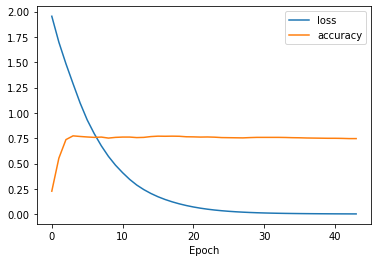

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(test_acc, label='accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
